### Pipeline Stage 6: Final Matching

Welcome to Pipeline 6, the final stage of our process! In this stage, we will use the alignment scores generated in the previous stage to produce our final matches between students and job positions. 

The DataFrame used in this stage contains the alignment scores calculated from the student and position profiles in the previous stage, where I employed the GPT-4o-mini model to generate these scores.

This stage will focus on leveraging these alignment scores to determine the best matches, ensuring that each student is paired with the most suitable job opportunities based on the comprehensive analysis conducted throughout the pipeline.

In [3]:
import pandas as pd
from collections import defaultdict
from mypackage.utils import *
import os 
import re
import time 
from concurrent.futures import ThreadPoolExecutor, as_completed
import pandas as pd
from fuzzywuzzy import fuzz
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [ ]:
# Load the project path
path_to_project = load_project_path()

if path_to_project:
    print(f"Project path loaded: {path_to_project}")
else:
    print("Please set the project path in the initial notebook.")
    
SP_load_path = f'{path_to_project}/data/SP_table/SP5_post_matchy.parquet'
SP = pd.read_parquet(SP_load_path)
    

### Summary of the Matching Strategy

This is a similar strategy used in pipeline 4 when filtering based on keyword scores. This code implements an iterative matching strategy designed to ensure that each student is matched with no more than 5 companies, while prioritizing the highest alignment scores (`Extraction_total_points`) between students and companies.

#### Key Steps in the Matching Process:

1. **Initial Sorting:**
   - The DataFrame `SP` is sorted by `pos_(Do Not Modify) Job Posting` and `Extraction_total_points` in descending order. This ensures that for each company, the top matches (with the highest alignment scores) are prioritized.

2. **Iterative Matching Rounds:**
   - The matching process is conducted in multiple rounds. In each round, the top match for each company is selected from the remaining pool of students.

3. **Processing Top Matches:**
   - For each company in a given round, the top match (the student with the highest alignment score for that company) is identified and collected.

4. **Tracking Student Matches:**
   - The code maintains a dictionary (`student_matches`) that tracks all the matches for each student across all rounds.
   - After collecting new matches for the current round, the code ensures that each student retains only their top 2 matches based on `Overall Alignment Score`.

5. **Updating Final Matches:**
   - The selected matches (limited to the top 5 for each student) are added to the `final_matches` DataFrame, which accumulates all the valid matches throughout the process.

6. **Removing Fully Matched Students:**
   - Students who have reached their maximum of 2 matches are removed from the pool (`SP_sorted`). This ensures they are not considered in subsequent rounds, preventing over-matching.

7. **Loop Termination:**
   - The loop continues until no students are left in the pool (`SP_sorted.empty`), meaning all students have either reached their maximum matches or no suitable matches remain.

8. **Counting Rounds:**
   - The variable `num_rounds` tracks the number of iterations (rounds) needed to complete the matching process.

#### Output:
- The final output is a DataFrame `final_matches` that contains all the matches, limited to the top 2 matches per student, ensuring an optimal distribution based on alignment scores.
- Additionally, the number of rounds taken to complete the matching process is printed, providing insight into the efficiency of the matching strategy.

### Key Characteristics of the Strategy:
- **Prioritization of Top Matches:** The strategy consistently prioritizes the highest alignment scores for each company, ensuring that the best possible matches are made.
- **Controlled Match Distribution:** By limiting each student to a maximum of 2 matches, the strategy prevents any student from being over-matched, ensuring a fair distribution across all companies.
- **Iterative Approach:** The iterative nature of the strategy allows for flexibility, as it continuously re-evaluates and refines the matches until an optimal solution is reached.

This approach is efficient and ensures that the most aligned matches are prioritized while adhering to the constraint that no student is matched with more than 5 companies.

In [5]:
num_rounds = 0
# Step 1: Sort the DataFrame by company and alignment score
SP_sorted = SP.sort_values(by=['pos_(Do Not Modify) Job Posting', 'Overall Alignment Score'], ascending=[True, False])

# Initialize an empty DataFrame to store the final matches
final_matches = pd.DataFrame(columns=SP.columns)

# Initialize a dictionary to keep track of all student matches (not just counts)
student_matches = defaultdict(list)

# Set the maximum number of matches each company and student should get
max_matches_per_student = 2

# Iterative matching process
while not SP_sorted.empty:
    # Get the top match for each company
    top_matches = SP_sorted.groupby('pos_(Do Not Modify) Job Posting').head(1)

    # Initialize a list to collect matches for this round
    round_matches = []

    # Process each top match
    for index, row in top_matches.iterrows():
        student = row['stu_(Do Not Modify) Application']
        company = row['pos_(Do Not Modify) Job Posting']

        # Collect matches for each student
        round_matches.append(row)
    
    # Convert round_matches to DataFrame
    round_matches_df = pd.DataFrame(round_matches)

    # Update the student_matches dictionary with new matches
    for student in round_matches_df['stu_(Do Not Modify) Application'].unique():
        # Append new matches for this student
        student_matches[student].extend(round_matches_df[round_matches_df['stu_(Do Not Modify) Application'] == student].to_dict('records'))
        
        # Keep only the top 5 matches for the student
        student_matches[student] = sorted(student_matches[student], key=lambda x: x['Overall Alignment Score'], reverse=True)[:max_matches_per_student]

    # Create a DataFrame from the selected matches to add to final_matches
    selected_matches = pd.DataFrame([match for matches in student_matches.values() for match in matches])
    
    if num_rounds == 0:
        final_matches = selected_matches.copy()
        final_matches = final_matches.drop_duplicates().reset_index(drop=True)
    else:
        final_matches = pd.concat([final_matches, selected_matches]).drop_duplicates().reset_index(drop=True)


    # Remove students who have reached their maximum matches from SP_sorted
    fully_matched_students = [student for student, matches in student_matches.items() if len(matches) >= max_matches_per_student]
    SP_sorted = SP_sorted[~SP_sorted['stu_(Do Not Modify) Application'].isin(fully_matched_students)]
    
    num_rounds += 1
    
    # Stop if there are no more students to match

# final_matches now contains the distributed matches limited to the top 5 for each student
print(f"Number of rounds: {num_rounds}")

# if stu_(Do Not Modify) Application shows up more then 2 times, remove one of the rows with the lowest alignment score. If its a tie, remove the one with the highest index. 
final_matches = final_matches.sort_values(by=['stu_(Do Not Modify) Application', 'Overall Alignment Score'], ascending=[True, False])
final_matches = final_matches.groupby('stu_(Do Not Modify) Application').head(2)



Number of rounds: 16


In [6]:
''' 
We now have a dataframe containing the final matches. I will print the number of matches each company and student received.
'''
final_matches = final_matches.sort_values(by=['pos_(Do Not Modify) Job Posting', 'Overall Alignment Score'], ascending=[True, False])

pos_cols = ''' 
pos_Name
pos_Company
pos_(Do Not Modify) Job Posting
'''
pos_cols = as_list(pos_cols)

company_match_counts = final_matches[pos_cols].copy()

# add a column to company_match_counts that counts the number of matches each company received. This is done by counting the number of times 'pos_(Do Not Modify) Job Posting' shows up in the final_matches dataframe.
company_match_counts['num_matches'] = company_match_counts.groupby('pos_(Do Not Modify) Job Posting')['pos_(Do Not Modify) Job Posting'].transform('count')

# drop duplicates
company_match_counts = company_match_counts.drop_duplicates().reset_index(drop=True)

# sort by num_matches
company_match_counts = company_match_counts.sort_values(by='num_matches', ascending=False)

stu_cols = ''' 
stu_Legal Name
stu_(Do Not Modify) Application
'''

stu_cols = as_list(stu_cols)

student_match_counts = final_matches[stu_cols].copy()

# add a column to student_match_counts that counts the number of matches each student received. This is done by counting the number of times 'stu_(Do Not Modify) Application' shows up in the final_matches dataframe.
student_match_counts['num_matches'] = student_match_counts.groupby('stu_(Do Not Modify) Application')['stu_(Do Not Modify) Application'].transform('count')

# drop duplicates
student_match_counts = student_match_counts.drop_duplicates().reset_index(drop=True)

# sort by num_matches
student_match_counts = student_match_counts.sort_values(by='num_matches', ascending=False)

In [7]:
print('Company match counts:')
pretty_print(company_match_counts[['pos_Company', 'pos_Name', 'num_matches']])

Company match counts:
+-------+----------------------------------+--------------------------------------------------------------------------+-------------+
| Index |           pos_Company            |                                 pos_Name                                 | num_matches |
+-------+----------------------------------+--------------------------------------------------------------------------+-------------+
|   45  |            Tech Firm             |                            IT Support Intern                             |      8      |
|   58  |      Creative Solutions Co.      |                        Content Specialist Intern                         |      8      |
|   22  |      Health Services Group       |                           Marketing Assistant                            |      8      |
|   20  |           Design Firm            |                           Marketing Internship                           |      8      |
|   69  |        Tech Supplies Co.      

In [8]:
print('Student match counts:')
pretty_print(student_match_counts[['stu_Legal Name', 'num_matches']])

Student match counts:
+-------+---------------------+-------------+
| Index |    stu_Legal Name   | num_matches |
+-------+---------------------+-------------+
|   0   |      Alex Smith     |      2      |
|  326  |     Alex Taylor     |      2      |
|  108  |     Alex Johnson    |      2      |
|  107  |      Alex Smith     |      2      |
|  106  |     Chris Nguyen    |      2      |
|  104  |     Alex Johnson    |      2      |
|  102  |      Alex Smith     |      2      |
|  101  |     Alex Johnson    |      2      |
|  100  |     Alex Morgan     |      2      |
|   99  |       Alex Doe      |      2      |
|   98  |     Alex Taylor     |      2      |
|  182  |     Alex Johnson    |      2      |
|   96  |       Alex Kim      |      2      |
|  333  |      Jordan Kim     |      2      |
|  280  |    Taylor Morgan    |      2      |
|   90  |     Jordan Smith    |      2      |
|   89  |       Alex Doe      |      2      |
|   88  |     Jordan Smith    |      2      |
|   87  |   

In [9]:
''' 
We will now only keep the top 4 matches for each company. Up to this point, no students have been removed from the matches. 
However, once we have the top 4 matches for each company, some students will be removed if they did not make the top 4 for any company.
All companies will be kept in the final matches.
'''

# Sort the DataFrame by 'pos_(Do Not Modify) Job Posting' and 'Extraction_total_points'
top4 = final_matches.sort_values(by=['pos_(Do Not Modify) Job Posting', 'Overall Alignment Score'], ascending=[True, False])

# Select the top 4 matches for each 'pos_(Do Not Modify) Job Posting'
top4 = top4.groupby('pos_(Do Not Modify) Job Posting').head(4).reset_index(drop=True)


company_match_counts = top4['pos_(Do Not Modify) Job Posting'].value_counts()
student_match_counts = top4['stu_(Do Not Modify) Application'].value_counts()

In [10]:
pretty_print(company_match_counts)

+------------+-------+
|   Index    | count |
+------------+-------+
| 1010409776 |   4   |
| 4534509563 |   4   |
| 6894490643 |   4   |
| 6714996254 |   4   |
| 6489535853 |   4   |
| 6472685494 |   4   |
| 6340854214 |   4   |
| 6243370056 |   4   |
| 6209551963 |   4   |
| 6134208785 |   4   |
| 6097358815 |   4   |
| 6035075361 |   4   |
| 5978783568 |   4   |
| 5905607153 |   4   |
| 5795287239 |   4   |
| 5794398872 |   4   |
| 5772319624 |   4   |
| 5758452426 |   4   |
| 5733854012 |   4   |
| 5649818733 |   4   |
| 5359990774 |   4   |
| 5333558749 |   4   |
| 1238007315 |   4   |
| 6936230631 |   4   |
| 7001674764 |   4   |
| 7082701328 |   4   |
| 9121700883 |   4   |
| 9956304551 |   4   |
| 9871822868 |   4   |
| 9859612597 |   4   |
| 9762986720 |   4   |
| 9687011376 |   4   |
| 9590756174 |   4   |
| 9379485397 |   4   |
| 9368667889 |   4   |
| 9226756788 |   4   |
| 8913168104 |   4   |
| 7094906896 |   4   |
| 8530650589 |   4   |
| 8409851114 |   4   |
| 813618984

In [11]:
print('Number of students:', len(student_match_counts))
print(f'Number of students who did not make the top 4 for any company: {len(final_matches["stu_(Do Not Modify) Application"].unique()) - len(student_match_counts)}')
pretty_print(student_match_counts)

Number of students: 324
Number of students who did not make the top 4 for any company: 67
+------------+-------+
|   Index    | count |
+------------+-------+
| 6109687097 |   2   |
| 4995534226 |   2   |
| 5754315466 |   2   |
| 6132589779 |   2   |
| 8655432961 |   2   |
| 7031987151 |   2   |
| 4140802866 |   2   |
| 1919681513 |   2   |
| 6409917241 |   2   |
| 1939324697 |   2   |
| 1902681619 |   2   |
| 7630292266 |   2   |
| 3311142718 |   2   |
| 8224864233 |   2   |
| 9763139109 |   2   |
| 8465964632 |   2   |
| 7438718005 |   2   |
| 3037480222 |   2   |
| 6014110033 |   2   |
| 6289043431 |   2   |
| 6335497663 |   2   |
| 6328441030 |   2   |
| 4508270528 |   2   |
| 6761481315 |   2   |
| 8703391515 |   2   |
| 2041961535 |   2   |
| 1078818246 |   2   |
| 9918446974 |   2   |
| 4967523338 |   2   |
| 2593382221 |   2   |
| 8201606125 |   2   |
| 4670577697 |   2   |
| 9106221859 |   2   |
| 4269921629 |   2   |
| 1274107142 |   2   |
| 6442247586 |   2   |
| 6295898974 

Pearson correlation coefficient: 0.3145617653505365
P-value: 1.6051261692191718e-10


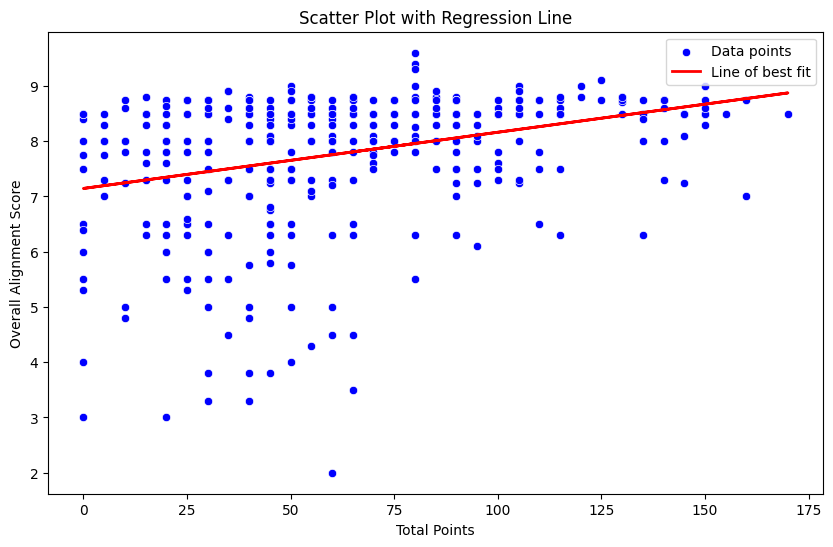

Regression slope: 0.010169452374755859
Regression intercept: 7.143974571516938


In [12]:
# below is code to plot the correlation between the total points and the overall alignment score.

# Calculate the Pearson correlation coefficient
def calculate_correlation(df):
    correlation, p_value = pearsonr(df['Total Points'], df['Overall Alignment Score'])
    print(f"Pearson correlation coefficient: {correlation}")
    print(f"P-value: {p_value}")
    return correlation

# Plot the scatter plot and regression line
def plot_regression(df):
    # Create scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Total Points', y='Overall Alignment Score', data=df, color='blue', label='Data points')

    # Perform linear regression
    X = df['Total Points'].values.reshape(-1, 1)
    y = df['Overall Alignment Score'].values
    reg = LinearRegression().fit(X, y)
    y_pred = reg.predict(X)

    # Plot regression line
    plt.plot(df['Total Points'], y_pred, color='red', linewidth=2, label='Line of best fit')
    
    # Add labels and title
    plt.xlabel('Total Points')
    plt.ylabel('Overall Alignment Score')
    plt.title('Scatter Plot with Regression Line')
    plt.legend()
    plt.show()

    print(f"Regression slope: {reg.coef_[0]}")
    print(f"Regression intercept: {reg.intercept_}")

# Perform the analysis on the DataFrame
def perform_correlation_analysis(df):
    # Step 1: Calculate correlation
    calculate_correlation(df)
    
    # Step 2: Plot and perform regression
    plot_regression(df)

# Assuming your DataFrame is called SP, you would run:
perform_correlation_analysis(top4)


### Plotting Total Points vs. Overall Alignment Score

This plot illustrates the relationship between total points and the overall alignment score for each student-job pair. The analysis shows a **Pearson correlation coefficient of 0.37**, indicating a weak positive correlation between these two variables. This means that as the total points increase, the overall alignment score tends to increase slightly, but the relationship is not strong.

The **p-value is less than 0.05**, suggesting that the observed correlation is statistically significant, even though the correlation itself is not very strong. This implies that the relationship between total points and overall alignment score is unlikely to have occurred by chance.

The regression line on the plot quantifies the relationship between these two variables:
- **Slope:** 0.01
- **Intercept:** 7.02

The slope of 0.01 suggests that for every one-point increase in total points, the overall alignment score is expected to rise by 0.01. The intercept of 7.02 indicates that even when the total points are zero, the overall alignment score is expected to be 7.02.

### Interpretation:
The analysis suggests that while there is some relationship between total points and overall alignment score, the weak correlation and the low slope of the regression line indicate that **total points may not be a strong predictor of overall alignment score**. Therefore, it may not be the most effective metric for evaluating the quality of matches in this context. This insight suggests that relying solely on total points might overlook other factors that contribute to a higher overall alignment score.

---

### Final Analysis

We can now look at some of the results from our final matches to help determine how well the matching pipeline performed.


In [13]:
# Below is a list of Companies from 2024. If you'd like to see the matches for a specific company, copy and paste the name in the 'company_name' variable below.

for company in top4['pos_Company'].unique():
    print(company)

Finance Solutions Group
Tech Group
Green Initiatives Organization
Innovative Firm
Running Gear Co.
Media Solutions Agency
Youth Development Organization
Healthcare Group
Health Network Inc.
Finance Cooperative
Youth Empowerment Initiatives
Tech Solutions
Footwear Innovators
Creative Media Studio
Healthcare Provider
Each Youth Organization
EcoConsulting Group
Non-Profit Organization
Advertising Solutions Firm
Tech Innovators
Design Firm
Local Financial Institution
Health Services Group
Innovate Group
The Collective Group
Nature Conservation Group
Realty Group
Finance Associates
Global Finance Firm
Media Group
Creative Agency
Environmental Consulting Group
Healthcare Solutions Inc.
Umbrella Tactics
CityDesigners Co.
Automotive Manufacturing Company
Media Enterprise
United Cider Organization
Community Financial Cooperative
Athletic Gear Company
Compass
Tech Firm
Tech Solutions Firm
Health Solutions Organization
Community Nonprofit
Tech Nonprofit
Collaboration Group
Tech Collective
Metro B

In [14]:
company_name = 'Finance Cooperative'

cols = ''' 
pos_Company
pos_Name
stu_Legal Name
Alignment Text
Overall Alignment Score
Company and Industry Alignment Score
Job Role and Responsibilities vs. Applicant Experience Score
Education, Technical Skills, and Tools Score
Values, perks, development opportunities, and Company Culture Alignment Score
pos_(Do Not Modify) Job Posting
stu_(Do Not Modify) Application
'''
cols = as_list(cols)

# create a subset of SP with the columns in cols
company_match = top4[cols]
company_match = (company_match[company_match['pos_Company'] == company_name])

# print legacy_health, order by 'Overall' in descending order
company_match = company_match.sort_values(by='Overall Alignment Score', ascending=False).head(4)

pretty_print(company_match)

+-------+---------------------+---------------------------+----------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------+--------------------------------------+--------------------------------------------------------------+----------------------------------------------+-------------------------------------------------------------------------------+---------------------------------+---------------------------------+
| Index |     pos_Company     |          pos_Name        

In [15]:
cols = ''' 
pos_Company
pos_Name
stu_Legal Name
Overall Alignment Score
pos_(Do Not Modify) Job Posting
'''

cols = as_list(cols)

number_1_match_alignment = top4[cols]

number_1_match_alignment = number_1_match_alignment.sort_values(by='Overall Alignment Score', ascending=False)

# get the number 1 match of each company
number_1_match_alignment = number_1_match_alignment.groupby('pos_(Do Not Modify) Job Posting').head(1)

pretty_print(number_1_match_alignment)

+-------+----------------------------------+--------------------------------------------------------------------------+------------------+-------------------------+---------------------------------+
| Index |           pos_Company            |                                 pos_Name                                 |  stu_Legal Name  | Overall Alignment Score | pos_(Do Not Modify) Job Posting |
+-------+----------------------------------+--------------------------------------------------------------------------+------------------+-------------------------+---------------------------------+
|  185  |       Community Nonprofit        |                        Digital Engagement Intern                         |   Jamie Smith    |           9.6           |            4534509563           |
|   40  |  Youth Empowerment Initiatives   |                       Marketing and Design Intern                        |   Alex Harper    |           9.4           |            1793232456           |
|  12

This table shows the alignment scores for the number 1 match for each company. An alignment score above 8 is considered a strong match. Only 9 companies have an alignment score below 8. This suggests that the matching algorithm has been successful in identifying strong matches for most companies. The alignment scores can be used to evaluate the quality of the matches and identify areas for improvement in the matching process. Further analysis of the results can be found in the final report.

---

Below we will be looking at the generated scores and text from the top matches from each company. It is sorted in decending order, so unsuccessful matches can be found at the bottom of the table.

In [16]:
# print the number 1 match for each company
top1 = top4.groupby('pos_(Do Not Modify) Job Posting').head(1)

# order top1 by 'Overall Alignment Score' in ascending order
top1 = top1.sort_values(by='Overall Alignment Score', ascending=False)

cols = ''' 
stu_Legal Name
pos_Name
pos_Company
Alignment Text
Overall Alignment Score
Company and Industry Alignment Score
Job Role and Responsibilities vs. Applicant Experience Score
Education, Technical Skills, and Tools Score
Values, perks, development opportunities, and Company Culture Alignment Score
stu_(Do Not Modify) Application
pos_(Do Not Modify) Job Posting
'''

cols = as_list(cols)

top1 = top1[cols]

pretty_print(top1)


+-------+------------------+--------------------------------------------------------------------------+----------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------+--------------------------------------+--------------------------------------------------------------+----------------------------------------------+-----------------------------------------------------------------